In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.util import operators
from src.hops import hops
from src.homps import homps
from src.util import noise_generator

In [64]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta_1 = 0.5
beta_2 = 50
T_1 = 1/beta_1
T_2 = 1/beta_2
gamma_1 = 0.25
gamma_2 = 5
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [65]:
N_terms = 100000
g_1, w_1 = debye_spectral_density.get_debye_coefficients(N_terms, T_1, gamma_1, eta)
g_alternative_1, w_alternative_1 = debye_spectral_density.get_debye_coefficients(N_terms, T_1, gamma_1, eta, use_alternative_expansion=True)
g_2, w_2 = debye_spectral_density.get_debye_coefficients(N_terms, T_2, gamma_2, eta)
g_alternative_2, w_alternative_2 = debye_spectral_density.get_debye_coefficients(N_terms, T_2, gamma_2, eta, use_alternative_expansion=True)

In [66]:
J_1 = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma_1)
J_2 = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma_2)

In [67]:
def compute_gamma_terminator(N_terms):
    return np.sum(g_alternative_1[N_terms:]/w_alternative_1[N_terms:])

# High temperature case

In [68]:
N_terms = 1

In [69]:
N_steps = 500
N_trunc = 40

In [70]:
N = 10000
w_cut = 1000

### HOMPS (RK4)

In [71]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J_1, 0, duration, N, w_cut, beta_1)

In [72]:
N_memory = 3
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True,
    'noise_generator' : generator,
    'g_memory' : g_1[:N_memory],
    'w_memory' : w_1[:N_memory],
}

In [73]:
options['use_noise'] = False
my_homps = homps.HOMPS_Engine(g_1[:1], w_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_1_compare = my_homps.compute_realizations(1, progressBar=tqdm)
options['use_noise'] = True
my_homps = homps.HOMPS_Engine(g_1[:1], w_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_100_compare = my_homps.compute_realizations(100, progressBar=tqdm)
my_homps = homps.HOMPS_Engine(g_1[:1], w_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_1000_compare = my_homps.compute_realizations(1000, progressBar=tqdm)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
sigma_zs_1_compare = compute_exp_val_nonlinear(psis_1_compare, sigma_z)
sigma_zs_100_compare = compute_exp_val_nonlinear(psis_100_compare, sigma_z)
sigma_zs_1000_compare = compute_exp_val_nonlinear(psis_1000_compare, sigma_z)

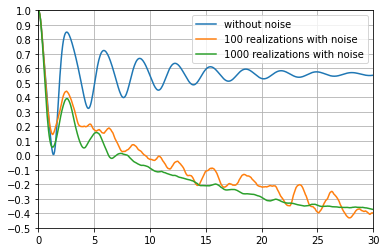

In [75]:
plt.plot(np.linspace(0, duration, 500), sigma_zs_1_compare, label="without noise")
plt.plot(np.linspace(0, duration, 500), sigma_zs_100_compare, label="100 realizations with noise")
plt.plot(np.linspace(0, duration, 500), sigma_zs_1000_compare, label="1000 realizations with noise")
plt.legend()
plt.ylim(-.5, 1)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.xlim(0, duration)
plt.grid()
plt.show()

### alternative HOMPS (RK4)

In [76]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J_1, 0, duration, N, w_cut, beta_1, use_alternative_expansion=True)

In [77]:
N_memory = 3
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True,
    'noise_generator' : generator,
    'g_memory' : g_alternative_1[:N_memory],
    'w_memory' : w_alternative_1[:N_memory],
    'alternative_realization' : True,
    'gamma_terminator' : compute_gamma_terminator(1),
}

In [78]:
options['use_noise'] = False
my_homps = homps.HOMPS_Engine(g_alternative_1[:1], w_alternative_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_1 = my_homps.compute_realizations(1, progressBar=tqdm)
options['use_noise'] = True
my_homps = homps.HOMPS_Engine(g_alternative_1[:1], w_alternative_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_100 = my_homps.compute_realizations(100, progressBar=tqdm)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
my_homps = homps.HOMPS_Engine(g_alternative_1[:1], w_alternative_1[:1], h, L, duration, N_steps, N_trunc, options)
psis_1000 = my_homps.compute_realizations(1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
sigma_zs_1 = compute_exp_val_nonlinear(psis_1, sigma_z)
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000, sigma_z)

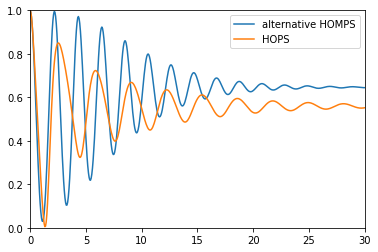

In [84]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1, label="alternative HOMPS")
plt.plot(np.linspace(0, duration, 500), sigma_zs_1_compare, label="HOPS")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, duration)
plt.show()

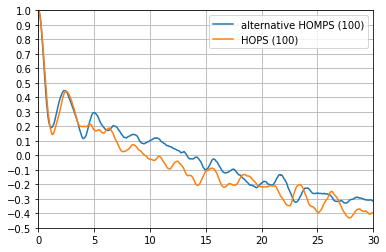

In [85]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="alternative HOMPS (100)")
plt.plot(np.linspace(0, duration, 500), sigma_zs_100_compare, label="HOPS (100)")
plt.legend()
plt.ylim(-.5, 1)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.xlim(0, duration)
plt.grid()
plt.show()

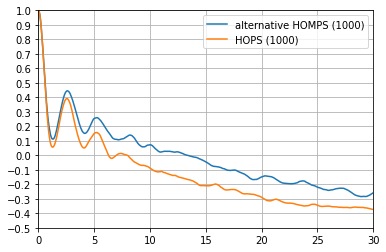

In [86]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="alternative HOMPS (1000)")
plt.plot(np.linspace(0, duration, 500), sigma_zs_1000_compare, label="HOPS (1000)")
plt.legend()
plt.ylim(-.5, 1)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.xlim(0, duration)
plt.grid()
plt.show()

# Low temperature case

In [ ]:
N_steps = 6000
N_terms = 12
N_trunc = 10

In [ ]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J_2, 0, duration, N, w_cut, beta_2, use_alternative_expansion=True)

In [39]:
N_memory = 4300
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'rescale_aux' : True,
    'noise_generator' : generator,
    'g_memory' : g_alternative_1[:N_memory],
    'w_memory' : w_alternative_1[:N_memory],
    'alternative_realization' : True,
    'gamma_terminator' : compute_gamma_terminator(N_terms),
}

(0.012740501578737767+0j)
(-0.07325034239989829+0.25j)


In [226]:
my_homps = homps.HOMPS_Engine(g_alternative[:N_terms], w_alternative[:N_terms], h, L, duration, N_steps, N_trunc, options)

  0%|          | 0/1 [00:00<?, ?it/s]

detected keyboard interrupt.


In [ ]:
psis_100 = my_homps.compute_realizations(100, progressBar=tqdm)